In [1]:
%matplotlib inline

from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
from pathlib import Path
import nest_asyncio
nest_asyncio.apply()



In [2]:

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_probability.python.bijectors as tfb

from bayesianquilts.models.logistic_regression import LogisticRegression
from bayesianquilts.metrics.classification import classification_metrics
from bayesianquilts.sampler import psis, nppsis

2024-02-07 21:53:28.879017: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 21:53:29.001830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 21:53:29.001926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 21:53:29.024960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 21:53:29.075353: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 21:53:29.075953: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:

X_ = pd.read_csv(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overianx.csv", header=None)
y_ = pd.read_table(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overiany.csv", header=None)


X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0).to_numpy()
y_ = y_.to_numpy()
N = X_scaled.shape[0]
d = X_scaled.shape[1]

print((N, d))

(54, 1536)


In [4]:
logistic_horseshoe_code = """
data {
  int <lower=0> N;                // number  of  observations
  int <lower=0> d;                // number  of  predictors
  array[N] int<lower=0,upper=1> y;      // outputs
  matrix[N,d] x;                  // inputs
  real <lower=0>  scale_icept;    // prior  std for  the  intercept
  real <lower=0>  scale_global;   // scale  for  the half -t prior  for  tau
  real <lower=1>  nu_global;      // degrees  of  freedom  for the half -t prior for tau
  real <lower=1> nu_local;        // degrees  of  freedom  for  the half -t priors for  lambdas
  real <lower=0>  slab_scale;     // slab  scale  for  the  regularized  horseshoe
  real <lower=0> slab_df;         // slab  degrees  of  freedom  for the  regularized horseshoe

  //int<lower=0> N_tilde;
  //matrix[N_tilde, d] x_tilde;
  //array[N_tilde] int<lower=0,upper=1> y_obs;
}
parameters {
  real  beta0;
  vector[d] z;
  real <lower=0> tau;             // global  shrinkage  parameter
  vector <lower =0>[d] lambda;    // local  shrinkage  parameter
  real <lower=0> caux;
}
transformed  parameters {
  vector <lower =0>[d] lambda_tilde;    // ’truncated ’ local  shrinkage  parameter
  real <lower=0> c;                     // slab  scale
  vector[d] beta;                       // regression  coefficients
  vector[N] f;                          // latent  function  values
  c = slab_scale * sqrt(caux);
  lambda_tilde = sqrt( c^2 * square(lambda) ./ (c^2 + tau^2* square(lambda )) );
  beta = z .*  lambda_tilde*tau;
  f = beta0 + x*beta;
}
model {
  z ~ normal(0.0, 1.0); // half -t priors  for  lambdas  and tau , and  inverse -gamma  for c^2
  lambda ~ student_t(nu_local , 0.0, 1.0);
  tau ~ student_t(nu_global , 0.0, scale_global);
  caux ~ inv_gamma (0.5* slab_df , 0.5* slab_df );
  beta0 ~ normal(0.0,  scale_icept );
  y ~ bernoulli_logit(f);
}
generated quantities {
  vector[N] log_lik;
  // vector[N_tilde] loo_log_lik;

  for (nn in 1:N)
    log_lik[nn] = bernoulli_logit_lpmf(y[nn] | x[nn] * beta + beta0);

  //for (nn in 1:N_tilde)
  //  loo_log_lik[nn] = bernoulli_logit_lpmf(y_obs[nn] | x_tilde[nn] * beta + beta0);
}
"""

with open("ovarian_model.stan", 'w') as f:
  f.writelines(logistic_horseshoe_code)


In [5]:
sm = CmdStanModel(stan_file="ovarian_model.stan")

21:53:32 - cmdstanpy - INFO - compiling stan file /home/josh/workspace/bayesianquilts/notebooks/ovarian_model.stan to exe file /home/josh/workspace/bayesianquilts/notebooks/ovarian_model
21:54:00 - cmdstanpy - INFO - compiled model executable: /home/josh/workspace/bayesianquilts/notebooks/ovarian_model


In [6]:
guessnumrelevcov = N/100 #20.
slab_scale = 2.5
scale_icept = 5.0
nu_global = 1
nu_local = 1
slab_df = 1
scale_global = guessnumrelevcov / ((d - guessnumrelevcov) * np.sqrt(N))

control = {"adapt_delta": 0.9995, "max_treedepth": 15}

ovarian_data = {
    "N": N,
    "d": d,
    "slab_df": slab_df,
    "slab_scale": slab_scale,
    "scale_icept": scale_icept,
    "nu_global": 1,
    "nu_local": 1,
    "scale_global": scale_global,
    "y": y_.astype(int)[:, 0].tolist(),
    "x": X_scaled.tolist(),
}

import json
with open("ovarian_data.json", 'w') as f:
    json.dump(ovarian_data, f)

In [7]:
fit = sm.sample(
    data="ovarian_data.json",
    iter_warmup=12000,
    iter_sampling=1000,
    thin=2,
    adapt_delta=0.9995,
    max_treedepth=15,
)

21:54:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:18:48 - cmdstanpy - INFO - CmdStan done processing.
22:18:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: ovarian_model_model_namespace::log_prob: lambda_tilde[1] is -nan, but must be greater than or equal to 0.000000 (in 'ovarian_model.stan', line 26, column 2 to column 36)
	Exception: ovarian_model_model_namespace::log_prob: lambda_tilde[1] is -nan, but must be greater than or equal to 0.000000 (in 'ovarian_model.stan', line 26, column 2 to column 36)
	Exception: ovarian_model_model_namespace::log_prob: lambda_tilde[1] is -nan, but must be greater than or equal to 0.000000 (in 'ovarian_model.stan', line 26, column 2 to column 36)
Exception: ovarian_model_model_namespace::log_prob: lambda_tilde[1] is -nan, but must be greater than or equal to 0.000000 (in 'ovarian_model.stan', line 26, column 2 to column 36)
Exception: ovarian_model_model_namespace::log_prob: lambda_tilde[365] is -nan, but must be greater than or equal to 0.000000 (in 'ovarian_model.stan', li

22:18:48 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [8]:
print(fit)

CmdStanMCMC: model=ovarian_model chains=4['method=sample', 'num_samples=1000', 'num_warmup=12000', 'thin=2', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'adapt', 'engaged=1', 'delta=0.9995']
 csv_files:
	/tmp/tmp5u00a4y8/ovarian_modelhwum1dhv/ovarian_model-20240207215400_1.csv
	/tmp/tmp5u00a4y8/ovarian_modelhwum1dhv/ovarian_model-20240207215400_2.csv
	/tmp/tmp5u00a4y8/ovarian_modelhwum1dhv/ovarian_model-20240207215400_3.csv
	/tmp/tmp5u00a4y8/ovarian_modelhwum1dhv/ovarian_model-20240207215400_4.csv
 output_files:
	/tmp/tmp5u00a4y8/ovarian_modelhwum1dhv/ovarian_model-20240207215400_0-stdout.txt
	/tmp/tmp5u00a4y8/ovarian_modelhwum1dhv/ovarian_model-20240207215400_1-stdout.txt
	/tmp/tmp5u00a4y8/ovarian_modelhwum1dhv/ovarian_model-20240207215400_2-stdout.txt
	/tmp/tmp5u00a4y8/ovarian_modelhwum1dhv/ovarian_model-20240207215400_3-stdout.txt


In [9]:
print(fit.diagnose())

Processing csv files: /tmp/tmp5u00a4y8/ovarian_modelhwum1dhv/ovarian_model-20240207215400_1.csv, /tmp/tmp5u00a4y8/ovarian_modelhwum1dhv/ovarian_model-20240207215400_2.csv, /tmp/tmp5u00a4y8/ovarian_modelhwum1dhv/ovarian_model-20240207215400_3.csv, /tmp/tmp5u00a4y8/ovarian_modelhwum1dhv/ovarian_model-20240207215400_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
1 of 2000 (0.05%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  z[1483], beta[93], beta[1483], beta[1504], log_lik[24]
Such high values indicate incomplete mi

In [10]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-2927.230000,1.291040,45.216800,-3001.470000,-2927.100000,-2.852130e+03,1226.650,3.90130,1.004670
beta0,2.437080,0.070753,1.886570,0.294097,1.955390,6.287830e+00,710.975,2.26121,1.006510
z[1],0.025178,0.024705,0.993321,-1.671120,0.015307,1.666570e+00,1616.590,5.14146,0.998954
z[2],0.046926,0.026113,1.037290,-1.609530,0.041809,1.802620e+00,1577.980,5.01866,1.001380
z[3],0.037744,0.024418,0.993393,-1.581180,0.047088,1.621680e+00,1655.110,5.26398,0.999280
...,...,...,...,...,...,...,...,...,...
log_lik[50],-0.010154,0.002308,0.053397,-0.043359,-0.000199,-1.017000e-13,535.291,1.70246,1.011340
log_lik[51],-0.008608,0.001436,0.046358,-0.037396,-0.000079,-2.720000e-14,1042.790,3.31655,1.004310
log_lik[52],-0.021451,0.004497,0.141958,-0.043949,-0.000103,-9.770000e-14,996.545,3.16945,1.000520
log_lik[53],-0.700586,0.066567,0.932015,-2.630360,-0.250988,-5.009960e-08,196.030,0.62346,1.013530


In [11]:
fit.stan_variable('beta0').shape

(2000,)

In [12]:
fit.stan_variable('beta').shape, X_scaled.shape

((2000, 1536), (54, 1536))

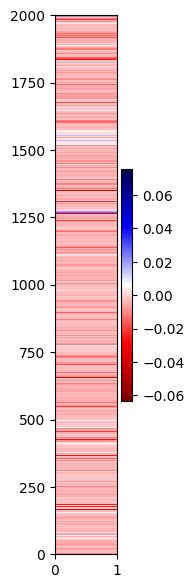

In [26]:
from matplotlib import pyplot as plt
beta = tf.reduce_mean(fit.stan_variable("beta"), axis=1, keepdims=True)
fig, ax = plt.subplots(1, 1, figsize=(1, 7))
im = ax.pcolormesh(beta, cmap='seismic_r')
plt.colorbar(im)

In [14]:
lr_model = LogisticRegression(dim_regressors=d, global_horseshoe_scale=1.)

In [27]:
n_samples = 128
params = lr_model.sample(n_samples)

In [28]:
fit.stan_variable("beta").shape

(2000, 1536)

In [29]:
params['beta__'] = tf.reshape(tf.cast(fit.stan_variable("beta")[:n_samples, np.newaxis, :], tf.float64), (n_samples, 1, 1536))

In [30]:
params['intercept__'] = tf.reshape(tf.cast(fit.stan_variable("beta0")[:n_samples], tf.float64), (n_samples, 1, 1))

In [31]:


tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})
batch_size = 56
def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

batch = next(iter(data_factory_factory()()))

1it [00:00, 45.57it/s]


(0.0, 1.0)

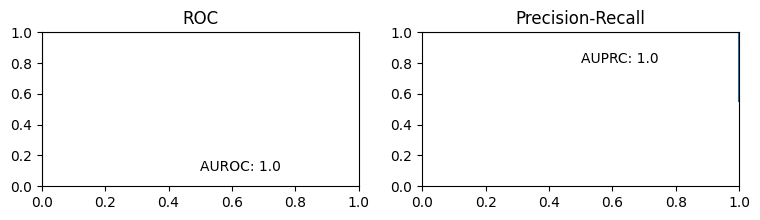

In [32]:
def prediction_fn(data):
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [52]:
def entropy(probs):
    return -tf.math.xlogy(probs, probs)


def adaptive_is_loo(self, data, params, hbar=1.0, variational=True):
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma
    beta = params["beta__"]
    intercept = params["intercept__"]
    X = tf.cast(data["X"], self.dtype)
    y = tf.cast(data["y"], self.dtype)[:, 0]
    mu = tf.reduce_sum(beta * X, axis=-1) + intercept[..., 0]
    sigma = tf.math.sigmoid(mu)
    ell = y * (sigma) + (1 - y) * (1 - sigma)
    log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
    log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
    log_ell_doubleprime = -sigma * (1 - sigma)
    _, khat0 = nppsis.psislw(-log_ell)

    """
    sigma.shape is samples x datapoints
    """

    # compute # \nabla\log\pi(\btheta|\calD)
    if variational:
        # \nabla\log\pi = -\Sigma^{-1}(theta - \bar{\theta})
        grad_log_pi = tf.concat(
            [
                -(intercept - self.surrogate_distribution.model["intercept__"].mean())
                / self.surrogate_distribution.model["intercept__"].variance(),
                -(beta - self.surrogate_distribution.model["beta__"].mean())
                / self.surrogate_distribution.model["beta__"].variance(),
            ],
            axis=-1,
        )
        intercept_sd = (
            self.surrogate_distribution.model["intercept__"].variance() ** 0.5
        )
        beta_sd = self.surrogate_distribution.model["beta__"].variance() ** 0.5

        log_pi = self.surrogate_distribution.model["beta__"].log_prob(
            params["beta__"]
        ) + self.surrogate_distribution.model["intercept__"].log_prob(
            params["intercept__"]
        )
        log_pi -= tf.reduce_max(log_pi, axis=0)
        # log_pi.shape: [samples]
    else:
        """
        Recall Bayes rule:
        \log pi(\btheta|\calD) = \sum_i\log ell_i(\btheta) + \log\pi(\btheta) + const

        so
        \nabla\log\pi(\btheta|\calD) = \sum_i (ell_i)'x + grad\log\pi(\btheta)

        """
        log_prior = self.prior_distribution.log_prob_parts(
            {
                "regression_model": {
                    k: tf.cast(params[k], self.dtype) for k in self.regression_var_list
                },
                "intercept_model": {
                    k: tf.cast(params[k], self.dtype) for k in self.intercept_var_list
                },
            }
        )
        
        log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]

        # pi \propto
        grad_log_pi = tf.concat(
            [
                tf.reduce_sum(log_ell_prime[..., tf.newaxis], axis=1, keepdims=True),
                tf.reduce_sum(
                    log_ell_prime[..., tf.newaxis] * X, axis=1, keepdims=True
                ),
            ],
            axis=-1,
        )

        grad_log_prior = tf.concat(
            [-0.5 * (intercept) ** 2, -0.5 * (beta) ** 2 / params["global_scale"] ** 2],
            axis=-1,
        )
        grad_log_pi += grad_log_prior

        prior_intercept_sd = (
            self.prior_distribution.model["intercept_model"]
            .model["intercept__"]
            .variance()
            ** 0.5
        )
        prior_beta_sd = params["global_scale"]

        intercept_sd = tf.math.reduce_std(intercept, 0, keepdims=True)
        beta_sd = tf.math.reduce_std(beta, 0, keepdims=True)

    # log-likelihood descent

    def T_ll():
        Q_beta = -log_ell_prime[..., tf.newaxis] * X
        Q_intercept = -log_ell_prime[..., tf.newaxis]

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized
        logJ = tf.math.log1p(
            tf.math.abs(
                h
                * (1 + tf.math.reduce_sum(X**2, -1, keepdims=True))[tf.newaxis, :, :]
                * (sigma * (1 - sigma))[..., tf.newaxis]
            )[..., 0]
        )
        beta_ll = beta + h * Q_beta
        intercept_ll = intercept + h * Q_intercept
        return beta_ll, intercept_ll, logJ

    def T_kl():
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        Q_beta = ((-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ] * X
        Q_intercept = (
            ((-1) ** y) * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (-1) ** y[tf.newaxis, :] * tf.math.exp(
            log_pi_[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :])
        )
        dQ *= (
            grad_log_pi[..., 0]
            + (1 - 2 * y)[tf.newaxis, :]
            + tf.reduce_sum(
                X
                * (
                    grad_log_pi[..., 1:]
                    + (1 - 2 * y)[:, tf.newaxis] * X[tf.newaxis, ...]
                ),
                axis=-1,
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept + h * Q_intercept
        beta_kl = beta + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    # variance descent -(log ell)'/l

    def T_I():
        Q = tf.zeros_like(log_ell)
        return (
            beta + Q[..., tf.newaxis],
            intercept + Q[..., tf.newaxis],
            tf.zeros_like(Q),
        )

    def T_var():
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)

        Q_beta = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis] * X
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(
                log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y[tf.newaxis, :])
            )
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + 2 * (1 - 2 * y)[:, tf.newaxis] * X),
                    axis=-1,
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept + h * Q_intercept
        beta_kl = beta + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def IS(Q):
        beta_new, intercept_new, logJ = Q()
        mu_new = tf.reduce_sum(beta_new * X, axis=-1) + intercept_new[..., 0]
        sigma_new = tf.math.sigmoid(mu_new)
        ell_new = y * (sigma_new) + (1 - y) * (1 - sigma_new)
        log_ell_new = tf.math.xlogy(y, sigma_new) + tf.math.xlogy(1 - y, 1 - sigma_new)
        transformed = params.copy()
        transformed["beta__"] = beta_new[..., tf.newaxis, :]
        transformed["intercept__"] = intercept_new[..., tf.newaxis, :]
        transformed["global_scale"] = transformed["global_scale"][..., tf.newaxis, :]
        transformed["global_scale_aux"] = transformed["global_scale_aux"][
            ..., tf.newaxis, :
        ]

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            # N_samples x N_data
            delta_log_pi = (
                self.surrogate_distribution.log_prob(transformed)
                - log_pi[:, tf.newaxis]
            )
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )
            pass
        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = tf.math.sigmoid(
                tf.reduce_sum(beta_new[..., tf.newaxis, :] * X, -1) + intercept_new
            )
            ell_cross = tf.math.xlogy(y, ell_cross) + tf.math.xlogy(
                1 - y, 1 - ell_cross
            )
            ell_cross = tf.math.reduce_sum(ell_cross, axis=-1)

            log_prior_new = self.prior_distribution.log_prob_parts(
                {
                    "regression_model": {
                        k: tf.cast(transformed[k], self.dtype)
                        for k in self.regression_var_list
                    },
                    "intercept_model": {
                        k: tf.cast(transformed[k], self.dtype)
                        for k in self.intercept_var_list
                    },
                }
            )
            log_pi_new = ell_cross
            delta_log_prior = log_prior_new['regression_model'] - log_prior['regression_model'][:, tf.newaxis]
            delta_log_prior += log_prior_new['intercept_model'] - log_prior['intercept_model'][:, tf.newaxis]
            # Incorporate the prior
            delta_log_pi = log_pi_new - log_pi[:, tf.newaxis] + delta_log_prior
        log_eta_weights = delta_log_pi - log_ell_new + logJ
        log_eta_weights = log_eta_weights - tf.reduce_max(log_eta_weights, axis=0)
        psis_weights, khat = nppsis.psislw(log_eta_weights)
        _, khat_test = nppsis.psislw(-log_ell_new-tf.reduce_max(-log_ell_new, axis=0))

        eta_weights = tf.math.exp(log_eta_weights)
        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = self.entropy(eta_weights)
        psis_entropy = self.entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        return (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis,
        )

    (
        eta_I,
        eta_I_psis,
        p_loo_I,
        p_loo_I_sd,
        ll_loo_I,
        ll_loo_I_sd,
        S_I,
        k_I,
        p_psis_I,
        ll_psis_I,
    ) = IS(T_I)

    (
        eta_kl,
        eta_kl_psis,
        p_loo_kl,
        p_loo_kl_sd,
        ll_loo_kl,
        ll_loo_kl_sd,
        S_kl,
        k_kl,
        p_psis_kl,
        ll_psis_kl,
    ) = IS(T_kl)

    (
        eta_var,
        eta_var_psis,
        p_loo_var,
        p_loo_var_sd,
        ll_loo_var,
        ll_loo_var_sd,
        S_var,
        k_var,
        p_psis_var,
        ll_psis_var,
    ) = IS(T_var)
    (
        eta_ll,
        eta_ll_psis,
        p_loo_ll,
        p_loo_ll_sd,
        ll_loo_ll,
        ll_loo_ll_sd,
        S_ll,
        k_ll,
        p_psis_ll,
        ll_psis_ll,
    ) = IS(T_ll)
    # kl descent

    return {
        "I": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I,
            "p_psis": p_psis_I,
            "ll_psis": ll_psis_I,
        },
        "KL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_kl,
            "khat": k_kl,
            "p_psis": p_psis_kl,
            "ll_psis": ll_psis_kl,
        },
        "LL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_ll,
            "khat": k_ll,
            "p_psis": p_psis_ll,
            "ll_psis": ll_psis_ll,
        },
        "Var": {
            "p_loo": p_loo_var,
            "p_loo_sd": p_loo_var_sd,
            "ll_loo": ll_loo_var,
            "ll_loo_sd": ll_loo_var_sd,
            "S": S_var,
            "khat": k_var,
            "p_psis": p_psis_var,
            "ll_psis": ll_psis_var,
        },
    }


loo = adaptive_is_loo(lr_model, batch, params, .1, variational=False)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "LL", "KL", "Var"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.5: {np.sum(loo[T]['khat']>0.7)}"
    )

I: 0.04658664699758072 entropy: 15.86779046685259 khat>0.5: 28
LL: 0.03619835780593503 entropy: 15.230111626938756 khat>0.5: 45
KL: 0.03619835780593503 entropy: 15.858189685894526 khat>0.5: 27
Var: 0.028645347657032152 entropy: 15.966350069335247 khat>0.5: 29


In [42]:
loo['I']['khat']

array([0.05853873, 1.18345948, 0.62422715, 0.75080435, 0.45679954,
       0.23080391, 1.20587186, 0.3944037 , 0.91819694, 0.70044812,
       0.34249801, 0.27731592, 0.98865735, 0.9915888 , 0.37728595,
       1.11143953, 0.25475469, 1.17583254, 0.90586615, 0.99305166,
       0.78882176, 0.73595196, 0.44515342, 0.43906085, 0.72971613,
       1.32906261, 0.86316453, 0.69583941, 0.87899702, 0.85601998,
       0.67221883, 0.294114  , 0.77092236, 1.07400484, 0.42458263,
       0.06658691, 0.63817512, 0.84882272, 0.83851141, 0.61866637,
       0.20321363, 1.18045048, 0.32973805, 0.74579885, 0.67458394,
       1.12847619, 0.82232308, 0.63921505, 0.6641723 , 0.47371854,
       1.24610846, 1.32061685, 0.58983865, 0.30038353])

In [43]:
loo["I"]['khat'] - loo['KL']['khat']

array([-0.04633901, -0.03167163, -0.08681974, -0.05864256,  0.05233831,
        0.02320619,  0.08555625,  0.08578372, -0.1526992 ,  0.04009756,
        0.03184764, -0.12229781, -0.1491799 ,  0.09159588,  0.11885243,
        0.20432815,  0.01982542,  0.32995193, -0.06176234,  0.12057784,
       -0.03875342, -0.27062678, -0.09670216, -0.00705996,  0.01243867,
        0.15832538,  0.14826428, -0.06631653, -0.03756527, -0.22507354,
       -0.00182825, -0.06423488,  0.04696244, -0.05192442,  0.0220676 ,
        0.00306887,  0.15734618, -0.09640077, -0.1014986 ,  0.01072718,
       -0.45991326, -0.00241392,  0.07411644, -0.22344046,  0.0096038 ,
       -0.00126388, -0.11270012, -0.31541231, -0.33829452, -0.34651333,
       -0.00854307,  0.09424755,  0.04520065, -0.20172259])